<a href="https://colab.research.google.com/github/yoooniverse/NLP/blob/main/SkipGramNegativeSampling_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Skip-Gram with Negative Sampling, SGNS


In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


required condition for sample : each sample must have at least two words to specify center, side word

loading data

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('total sample amount : ', len(documents))

total sample amount :  11314


preprocessing

In [3]:
news_df = pd.DataFrame({'document':documents})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-3-9eadbc3a8228>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [4]:
news_df.isnull().values.any()

False

In [5]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [6]:
news_df.dropna(inplace=True)
print('total sample amount : ', len(news_df))

total sample amount :  10995


In [7]:
#remove stopwords
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [8]:
#remove sample that have only one word
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('total sample amount : ', len(tokenized_doc))

total sample amount :  10940


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value: key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [10]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [11]:
vocab_size = len(word2idx) + 1
print('size of word set : ', vocab_size)

size of word set :  64277


making dataset by negative sampling

In [12]:
from tensorflow.keras.preprocessing.sequence import skipgrams

#for test, use only 10 samples to check data
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [13]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
  print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

(government (51), unfortunate (4295)) -> 1
(europe (1095), media (702)) -> 1
(shame (4988), blessing (10669)) -> 1
(government (51), inhuman (10668)) -> 1
(inhuman (10668), mornin (51521)) -> 0
(sure (59), disagree (1495)) -> 1
(think (6), embodies (60799)) -> 0
(power (68), kultur (37044)) -> 0
(shame (4988), existance (4865)) -> 1
(daily (1920), cgkwa (46880)) -> 0


In [14]:
print('total sample amount: ', len(skip_grams))

total sample amount:  10


In [15]:
print(len(pairs))
print(len(labels))

2220
2220


In [16]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]
#use all data and make dataset

Skip-Gram with Negative Sampling(SGNS) implementation

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

embedding vector dimension : 100, add 2 embedded layers

In [18]:
embedding_dim = 100

w_inputs = Input(shape=(1, ), dtype='int32')  #embedding table for center words
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

c_inputs = Input(shape=(1, ), dtype='int32')  #embedding table for side words
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

Each word goes through the embedding table to perform a dot product, and the result of the dot product goes through the sigmoid function as an activation function to predict 1 or 0 to obtain the final predicted value.

(각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻습니다.)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

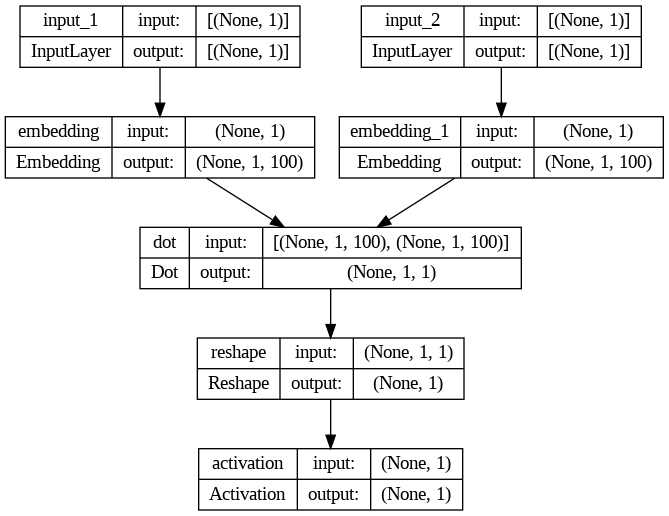

In [19]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [20]:
for epoch in range(5):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)
  
  print('Epoch :', epoch, 'Loss :', loss)

Epoch : 0 Loss : 4623.481886580586
Epoch : 1 Loss : 3679.2878067344427
Epoch : 2 Loss : 3528.0617338493466
Epoch : 3 Loss : 3324.858387714252
Epoch : 4 Loss : 3099.477132063359


results

In [21]:
import gensim

f = open('vectors.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)


In [22]:
w2v.most_similar(positive=['soldiers'])

[('villages', 0.8185509443283081),
 ('wounded', 0.8180254101753235),
 ('shelling', 0.7874764204025269),
 ('palestinian', 0.7806144952774048),
 ('refugees', 0.7746209502220154),
 ('homes', 0.773358941078186),
 ('fighting', 0.7708423733711243),
 ('murdered', 0.7599861025810242),
 ('occupation', 0.7597286701202393),
 ('moslem', 0.7541728019714355)]

In [23]:
w2v.most_similar(positive=['doctor'])

[('pain', 0.6024668216705322),
 ('medication', 0.5990849733352661),
 ('surgeons', 0.5720738172531128),
 ('migraine', 0.5604279041290283),
 ('lyme', 0.5563719272613525),
 ('patients', 0.5395789742469788),
 ('physician', 0.538523256778717),
 ('treatment', 0.5360425114631653),
 ('lesson', 0.5349249839782715),
 ('tissue', 0.5319048762321472)]

In [24]:
w2v.most_similar(positive=['police'])

[('officers', 0.5778818130493164),
 ('killed', 0.5579807758331299),
 ('criminals', 0.5523881912231445),
 ('civilians', 0.531825602054596),
 ('capitalist', 0.5302587747573853),
 ('violent', 0.5296058654785156),
 ('murder', 0.5288770198822021),
 ('crime', 0.5242619514465332),
 ('filed', 0.5231707692146301),
 ('prison', 0.5213598012924194)]

In [25]:
w2v.most_similar(positive=['knife'])

[('involvement', 0.6882692575454712),
 ('angry', 0.6838405728340149),
 ('erzincan', 0.6725208163261414),
 ('hama', 0.670825719833374),
 ('adhere', 0.6643483638763428),
 ('incidents', 0.6574407815933228),
 ('decay', 0.6573218107223511),
 ('timelessness', 0.6525330543518066),
 ('demands', 0.6501562595367432),
 ('propagandists', 0.6490907669067383)]

In [26]:
w2v.most_similar(positive=['engine'])

[('miles', 0.7141303420066833),
 ('pickup', 0.6123605966567993),
 ('brakes', 0.6035491824150085),
 ('shocks', 0.5657604336738586),
 ('racks', 0.545130729675293),
 ('rear', 0.5429490804672241),
 ('adjustable', 0.5298594236373901),
 ('valve', 0.5266818404197693),
 ('stock', 0.5227360725402832),
 ('brake', 0.5220241546630859)]